### Table of Contents

* [Chapter 1](#chapter1) Nettoyage des données


# Importation et analyse des données

In [ ]:
# import des librairies
import numpy as np
import pandas as pd
import glob
import scipy.stats as stats

## Les figures sont réalisées avec Plotly
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from   plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection

import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA

In [ ]:
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans, vq

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import confusion_matrix

In [ ]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [ ]:
from sklearn.pipeline import Pipeline

# Données visuelles

In [ ]:
path_data='/content/drive/MyDrive/OC Asma - Tahri/P06/Data/'
path_image= '/content/drive/MyDrive/OC Asma - Tahri/P06/Data/Flipkart/Images/'

In [ ]:
df = pd.read_csv(path_data+"Flipkart/flipkart_com-ecommerce_sample_1050.csv")

In [ ]:
df_desc_image = pd.read_csv(path_data+"df_desc_image.csv",index_col=0)
df_desc_image.sample(2)

,uniq_id,cat_level_0,product_name,description,brand,image
26,4aa047f14885c74f155ce5f973e14dff,Watches,"Disney 98189 Analog Watch - For Boys, Girls","Disney 98189 Analog Watch - For Boys, Girls -...",NaN,4aa047f14885c74f155ce5f973e14dff.jpg
143,a1fd886094826c3f25c6ffb380073974,Kitchen & Dining,Prithish Warm Up The Evil In Me Double Color C...,Buy Prithish Warm Up The Evil In Me Double Col...,NaN,a1fd886094826c3f25c6ffb380073974.jpg


In [ ]:
categories=df_desc_image['cat_level_0']
categories

0       Home Furnishing
1             Baby Care
2             Baby Care
3       Home Furnishing
4       Home Furnishing
             ...       
1045          Baby Care
1046          Baby Care
1047          Baby Care
1048          Baby Care
1049          Baby Care
Name: cat_level_0, Length: 1050, dtype: object

In [ ]:
import cv2 

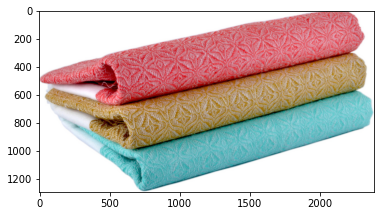

In [ ]:
# Exemple d'image:
image_test=df_desc_image[categories=='Baby Care']["image"].iloc[0]
pixels = plt.imread(path_image+image_test)
imgplot = plt.imshow(pixels)

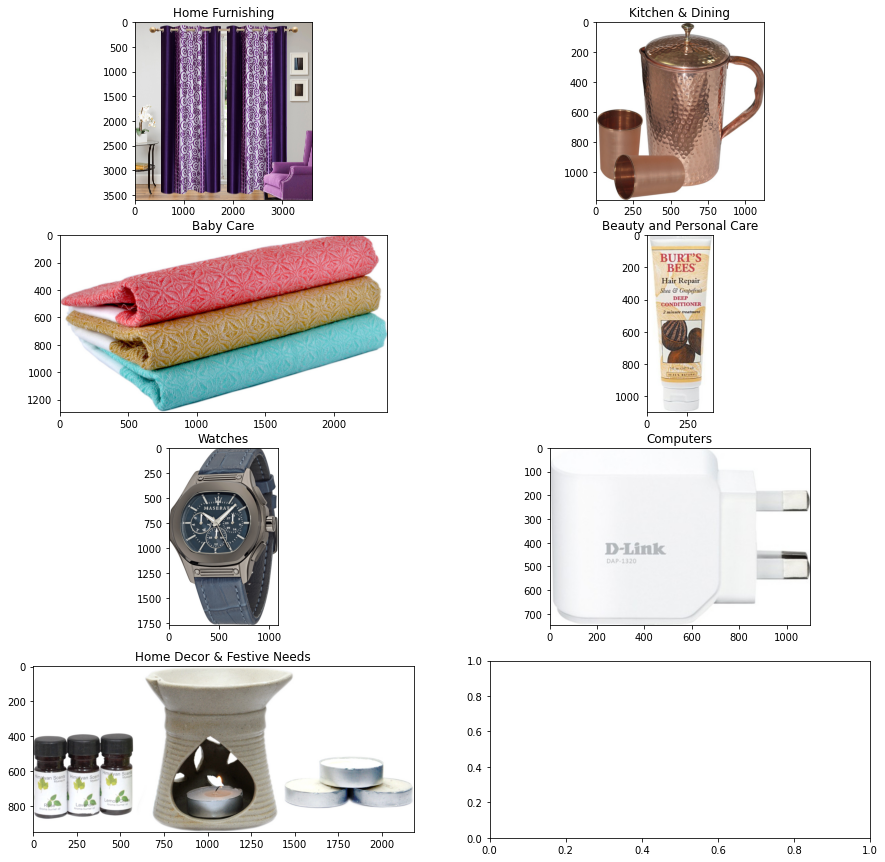

In [ ]:
# "Un exemple d'image pour chaque catégorie de niveau 0"
fig, ax = plt.subplots(4, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, categ in enumerate(categories.unique()) :
    name_image = df_desc_image[categories==categ]["image"].iloc[0]
    img = plt.imread(path_image + name_image)
    ax[i%4, i//4].set_title(categ)
    ax[i%4, i//4].imshow(img)
  
plt.show()

## Resizer les images

In [ ]:
import logging as lg
import os
from PIL import Image,ImageOps,ImageFilter


In [ ]:
#Fonction pour resizer et stocker les images :
def resize_image(filename,path):
    im = Image.open(filename)
    
    new_size=(224,224)
    im_resized = im.resize(new_size)
    im_resized.save(save_filename(filename,path))

In [ ]:
# Fonction pour sauvegareder les images resizées:
def save_filename(i,path):
  return (path+f'resized/{i.split("/")[-1]}')

In [ ]:
# Fonction pour créer des nouveaux dossiers:
def new_folder(path,name):
  try:
    os.mkdir(path+name)
    print('Le dossier:{}'.format(name)+' est créé')
  except FileExistsError as e:
    lg.warning('Message: {}'.format(os.strerror(e.errno)))
  except:
    print(os.strerror(e.errno))

In [ ]:
# Créer un dossier pour stocker les images resizées:
new_folder(path_image,'resized')

In [ ]:
# Créer un dossier pour stocker les images transformer:
new_folder(path_image,'Trans')

In [ ]:
path_res=path_image+'resized/'

## Image pre-processing:

In [ ]:
path_trans=path_image+'Trans/'

In [ ]:
for im in df_desc_image['image'].tolist():
      resize_image(path_image+im,path_image)


In [ ]:
# Images preprocessing:

preprocess_image = True
Images = []

if preprocess_image:

    for im in df_desc_image["image"] :

        img = Image.open(path_res+im) # Lecture de l'image
        img = ImageOps.autocontrast(img) # Auto contrast
        img = ImageOps.equalize(img) # Egalisation de l'histogramme
        img.save(path_trans + im) # Sauvegarde de l'image

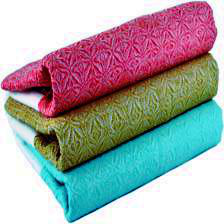

In [ ]:
# image_test après transformation:
im = np.array(Image.open(path_trans+image_test))
Image.fromarray(im)


### ORB + BoVW

ORB(Orienté FAST and Rotated BRIEF) est une fusion du détecteur de points clés FAST et du descripteur BRIEF avec quelques fonctionnalités supplémentaires pour améliorer les performances.

En effet, ORB supporte aussi la détection des rotations non pris en charge par le BRIEF.

A cette méthode nous rajoutons la méthode de Bag of Words Visual:
même principe que le BoW, en comptant cette fois la fréquence de chaque feature par image.

In [ ]:
df_desc_image

,uniq_id,cat_level_0,product_name,description,brand,image
0,55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Elegance,55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,7b72c92c2f6c40268628ec5f14c6d590,Baby Care,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas,7b72c92c2f6c40268628ec5f14c6d590.jpg
2,64d5d4a258243731dc7bbb1eef49ad74,Baby Care,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,Eurospa,64d5d4a258243731dc7bbb1eef49ad74.jpg
3,d4684dcdc759dd9cdf41504698d737d8,Home Furnishing,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,SANTOSH ROYAL FASHION,d4684dcdc759dd9cdf41504698d737d8.jpg
4,6325b6870c54cd47be6ebfbffa620ec7,Home Furnishing,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,Jaipur Print,6325b6870c54cd47be6ebfbffa620ec7.jpg
...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,Baby Care,Oren Empower Extra Large Self Adhesive Sticker,Oren Empower Extra Large Self Adhesive Sticker...,Oren Empower,958f54f4c46b53c8a0a9b8167d9140bc.jpg
1046,fd6cbcc22efb6b761bd564c28928483c,Baby Care,Wallmantra Large Vinyl Sticker Sticker,Wallmantra Large Vinyl Sticker Sticker (Pack o...,Wallmantra,fd6cbcc22efb6b761bd564c28928483c.jpg
1047,5912e037d12774bb73a2048f35a00009,Baby Care,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,Uberlyfe,5912e037d12774bb73a2048f35a00009.jpg
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,Baby Care,Wallmantra Medium Vinyl Sticker Sticker,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,Wallmantra,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg


In [ ]:
path_trans

'/content/drive/MyDrive/OC Asma - Tahri/P06/Data/Flipkart/Images/Trans/'

In [ ]:
clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(8,8)) 

def traitement_image(img):
    # conversion en noir et blanc
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Amélioration du contraste
    cl = clahe.apply(img_gray)  
    return cl

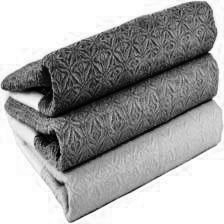

In [ ]:
# Image test avec application de noir&blanc:
im=np.array(Image.open(path_trans+image_test))
img_gray_test= cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
Image.fromarray(img_gray_test)

In [ ]:
# image test après application de clahe:
clahe_test = clahe.apply(img_gray_test)
clahe_test

array([[255, 255, 255, ..., 254, 253, 251],
       [255, 255, 255, ..., 254, 253, 251],
       [255, 255, 255, ..., 254, 253, 251],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [ ]:
# Extraction des features de chaque image sous forme de liste
# Création d'une liste des noms des images

images = []
des_list = []
image_path_to_del = []

orb = cv2.ORB_create()

for image_id in df_desc_image['image']:
    images.append(image_id)
    im = cv2.imread(os.path.join(path_image, image_id))
    im = traitement_image(im)
    kpts, des = orb.detectAndCompute(im, None)
    if des is not None : # Si descriptor est différent de None
        des_list.append((image_id, des))
    else :
        print("Descriptors of Image {} is None".format(image_id))
        image_path_to_del.append(image_id)

image_path_to_del

Descriptors of Image 9743e6d1c9f3180483825fe4d2e97836.jpg is None


['9743e6d1c9f3180483825fe4d2e97836.jpg']

In [ ]:
data_vis = df_desc_image.drop(df_desc_image[df_desc_image['image']==image_path_to_del[0]].index)

In [ ]:
# Empillement vertical des descriptors dans un numpy array
descriptors = des_list[0][1] # liste[début:fin:pas]
for image_path, descriptor in des_list[1:] :
    descriptors = np.vstack((descriptors, descriptor))  

descriptors_float = descriptors.astype(float)  
print(descriptors_float)

[[ 72. 189.  49. ...   2.   7. 191.]
 [142. 123. 103. ... 167.  39. 241.]
 [195. 170. 174. ... 196. 219. 205.]
 ...
 [ 40. 164. 169. ... 200. 145. 240.]
 [119.  39. 232. ... 175. 120.  84.]
 [  3. 150.  55. ...   4. 161. 125.]]


In [ ]:
# Construction des Bags Of Visual Words / histogramme prenant la forme d'une matrice
# pour des clusters de 100, 200 et 300:
from scipy.cluster.vq import kmeans, vq

BOVW = {}
n_clusters = [100, 200, 300]

for n in n_clusters:
    voc, variance = kmeans(descriptors_float, n, 1) 
    print(n)
    
    BOVW[n] = np.zeros((len(des_list), n), "float32")
    for i in range(len(des_list)):
        words, distance = vq(des_list[i][1],voc)
        for w in words:
            BOVW[n][i][w] += 1
    print('BovW ok')

100
BovW ok
200
BovW ok
300
BovW ok


(1049, 34)


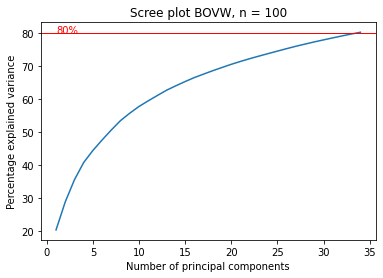

(1049, 71)


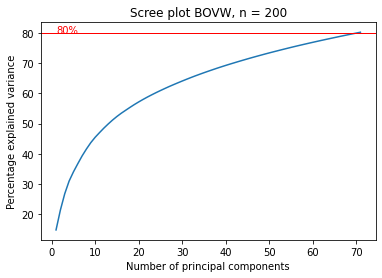

(1049, 105)


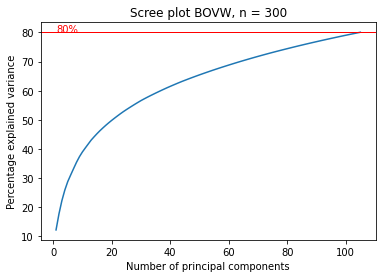

In [ ]:
# Réduction PCA / t-SNE des BOVW

tsne_results_BOVW = {}

for key, value in BOVW.items():
    pca = PCA(n_components=0.8, random_state=22)
    pca.fit(value)
    x = pca.transform(value)
    print(x.shape)

    # Scree plot
    scree = pca.explained_variance_ratio_*100
    plt.plot(np.arange(len(scree))+1, scree.cumsum()) #,c="red",marker='o')
    plt.xlabel("Number of principal components")
    plt.ylabel("Percentage explained variance")
    plt.axhline(80, lw=1, c='red')
    plt.text(1, 80, '80%', c='red')
    plt.title("Scree plot BOVW, n = {}".format(key))
    plt.show(block=False)

    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=1)
    tsne_results = tsne.fit_transform(x)
    
    tsne_results_BOVW[key] = tsne_results

In [ ]:
# Calcul du Coef ARI selon le nombre de centre de clusters/ visual words testés

score = {}
labels = {}

for key, value in tsne_results_BOVW.items():

    kmeans = KMeans(n_clusters=data_vis['cat_level_0'].nunique(),n_jobs=-1, random_state=22)
    kmeans.fit(value)
    labels[key]=kmeans.labels_
    print('nombre de visual words = {}'.format(key))
    score[key] = adjusted_rand_score(data_vis['cat_level_0'], kmeans.labels_)
    print('ARI = {}'.format(score[key]))
    print('\n')

nombre de visual words = 100
ARI = 0.04950602628240507


nombre de visual words = 200
ARI = 0.046183226378494126


nombre de visual words = 300
ARI = 0.042408147621063895




In [ ]:
dict_y_pred = {}
dict_tsne_results={}

In [ ]:
# Clé du dict score avec valeur maximale
key_max = max(score, key=score.get)
print('ARI_max = {}'.format(score[key_max]))

# Stockage du résultat
dict_y_pred['img_BOVW'] = labels[key_max]

dict_tsne_results['img_BOVW']=tsne_results_BOVW[key_max]

ARI_max = 0.04950602628240507


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning

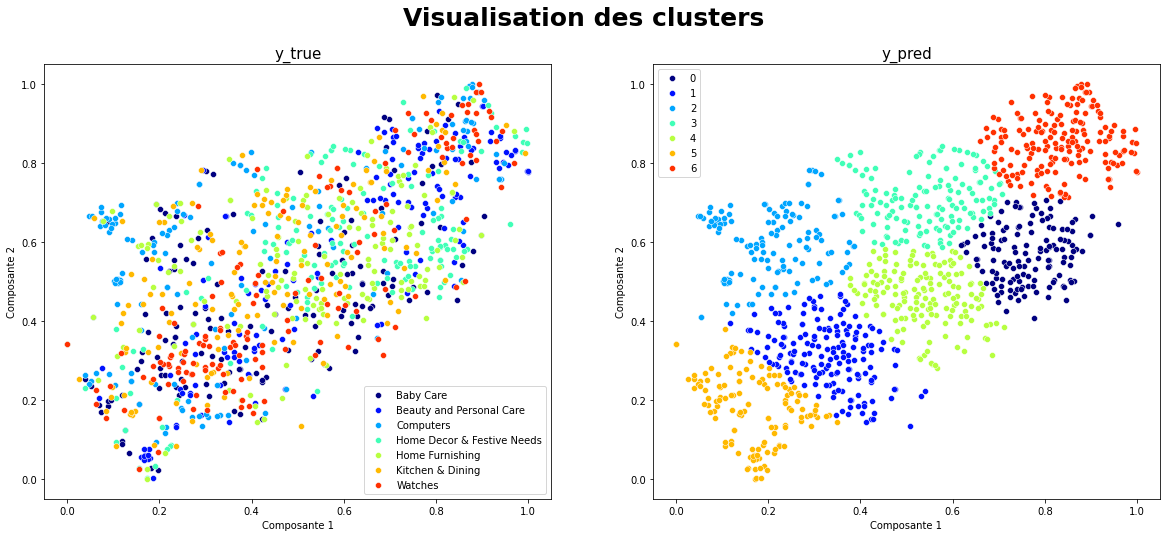

ARI = 0.04950602628240507


In [ ]:
# Visualisation 2D de y_pred et y_true
fig = plt.figure(1, figsize=(20, 8))
plt.suptitle("Visualisation des clusters", fontsize=25, fontweight='bold')

# Plot 1
plt.subplot(1, 2, 1)

X_normalized = MinMaxScaler().fit_transform(tsne_results_BOVW[key_max])
y_true =  data_vis['cat_level_0'].values

cmap = plt.cm.get_cmap("jet")
digits = np.unique(y_true)
for i, digit in enumerate(digits):
    sns.scatterplot(X_normalized[y_true == digit, 0],
                    X_normalized[y_true == digit, 1],
                    c=[cmap(i / 7)],
                    label=digit)

plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.title("y_true", fontsize=15)

# Plot 2
plt.subplot(1, 2, 2)

cmap = plt.cm.get_cmap("jet")
y_pred =  kmeans.labels_

digits = np.unique(y_pred)
for i, digit in enumerate(digits):
    sns.scatterplot(X_normalized[labels[key_max] == digit, 0],
                    X_normalized[labels[key_max] == digit, 1],
                    c=[cmap(i / 7)],
                    label=digit)

plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.title("y_pred", fontsize=15)

plt.show()

result = adjusted_rand_score(data_vis['cat_level_0'], labels[key_max])
print('ARI = {}'.format(result))

La prédiction obtenue est encore très loins de la réalité, avec un coef ARI de 0,04.

Nous allons continuer avec la méthode SIFT:

### SIFT

L'algorithme SIFT se divise en 2 étapes:

1-Detection : création de l'espace des échelles, calcul des "DoG", localisation des points d'intérêt

2-Description : assignation d'orientation, création des descripteurs


La méthodoligie d'extraction de features par SIFT se fait en 4 étapes :

* Récupérer les descripteurs de chaque image par un algorithme de type SIFT
* Clusteriser l'ensemble de tous les descripteurs
* Associer les descripteurs de chaque image aux centres obtenus par clustering
* Faire un bag of words des descripteurs de chaque image, pour toutes les images




In [ ]:
# Fonction pour récupérer les descriptors:
def gen_sift_features(gray_img):
    sift = cv2.xfeatures2d.SIFT_create()

    # kp is the keypoints
    #
    # desc is the SIFT descriptors, they're 128-dimensional vectors
    # that we can use for our final features
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

def show_sift_features(gray_img, color_img, kp):

    return plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))

In [ ]:
!pip3 install opencv-python==3.4.2.17
!pip3 install opencv-contrib-python==3.4.2.17

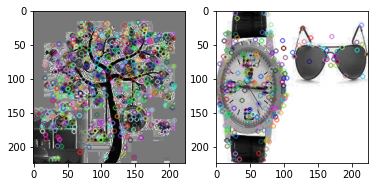

In [ ]:
# Exemple 1 d'une image
exemple_1 = cv2.imread(path_trans+ df["image"][1049])
# Exemple 2 d'une image
exemple_2 =  cv2.imread(path_trans+ df["image"][10])

# images N&B 
gray_1 = cv2.cvtColor(exemple_1, cv2.COLOR_BGR2GRAY)
gray_2 = cv2.cvtColor(exemple_2, cv2.COLOR_BGR2GRAY)

#create sift object
sift  = cv2.xfeatures2d.SIFT_create()
#calculate keypoints and their orientation
keypoints_1, descriptors_1 = sift.detectAndCompute(gray_1, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(gray_2, None)

#plot keypoints on the image
with_keypoints_1 = cv2.drawKeypoints(gray_1, keypoints_1, outImage=gray_1)
with_keypoints_2 = cv2.drawKeypoints(gray_2, keypoints_2, outImage=gray_2)

#plot the image
fig, ax = plt.subplots(1, 2)

# Affichage des descripteurs Sift dans les deux images
ax[0].imshow(with_keypoints_1)
ax[1].imshow(with_keypoints_2)

plt.show()

On voit sur ces images d'exemples, les points d'interets pour la méthode SIFT, sur les quels il se base pour classifier les images.

In [ ]:
from sklearn.preprocessing import normalize

In [ ]:
def sift_features_centers(df, categories, n_centers, path=path_trans) :
    
    """
    Pour chaque image, applique l'algorithme SIFT pour détecter les descripteurs.
    Ensuite, un k-means est appliqué sur l'ensemble de tous les descripteurs
    puis pour chaque image prise individuellement, k-means prédit pour chaque descripteur le centre associé
    Retourne une liste de liste, lenght=nombre d'images et pour chaque image correspond une liste dont
    la taille est égale au nombre de descripteurs détectés par l'algorithme SIFT
    df(pd.DataFrame): contient 'image' qui correspond au nom de l'image, 'categories' qui est l'étiquette
    de chaque produit
    
    """
    
    images = []
    labels = []
    descripteurs = []
    index_to_del = []
    images_desc = []

    sift  = cv2.xfeatures2d.SIFT_create()


    for i, image_id in df["image"].iteritems() : # Pour chaque image du jeu de données
        image = cv2.imread(path + image_id)

        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


        keypoints, descriptors = sift.detectAndCompute(gray_image, None) 



        if (descriptors is not None) : # Si la description <> de None
            images.append(np.array(gray_image)) 
            for des in descriptors : 
                descripteurs.append(normalize(des.reshape(1, -1)).ravel()) 
            labels.append(categories.loc[i])
            images_desc.append(normalize(descriptors))
        else :
            print("Descriptors of Image n° {} is None".format(index))
            index_to_del.append(index)


    descripteurs = np.array(descripteurs)
    labels = np.array(labels)

    km = KMeans(n_clusters=n_centers)

    km.fit(descripteurs)
    centers = []

    for desc in images_desc :
        centers.append(km.predict(desc))
    
    return centers


In [ ]:
X=sift_features_centers(df, categories, n_centers=10)

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin,TransformerMixin

In [ ]:
class Build_histogram(BaseEstimator, TransformerMixin) :
    """
    Transformateur en histogramme
    Chaque colonne représente un mot et sa fréquence associée
    
    """
    
    def __init__(self, n_centers):
        self.n_centers = n_centers
           
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):     
        result = np.array([[list(X[i]).count(k) for k in range(0, self.n_centers)] for i in range(len(X))])
        return result

In [ ]:
def define_pipeline(preprocessor, predictor) :
    """
    Assemblage des pipelines pré-traitement des données + clustering
        :preprocessor(transformator) : Transforme les données pour le prédicteur
        :predictor(predictor) : Effectue une prédiction
    
    """

    pipeline = Pipeline([("preprocess", preprocessor),
                         ("predictor", predictor),
                       ])
    return pipeline

In [ ]:
class Normalize(BaseEstimator, TransformerMixin) :
    
    """
    Classe Normalize qui permet de normaliser les données, en utilisant
    la syntaxe des pipelines de sklearn
    """
           
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return normalize(X, norm='l1', axis=1)

In [ ]:
# Pipeline Histogramme + Normalize
sift_pipeline = Pipeline(steps=[
        ('Build_histogram', Build_histogram(n_centers=500)), # Bag_of_visual_words
        ('normalize', Normalize()) # Normalisation de l'histogramme
    ])

# KMeans est rajouté au pipeline pour la segmentation
pipeline = define_pipeline(sift_pipeline, KMeans(n_clusters=categories.nunique()))

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold

skf = KFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
results_txt = {}
results_img = {}
grid_search_dict = {}
ARI_mean,ARI_std = {}, {}
score = cross_val_score(pipeline,
                        X, # Réduction de dimensions + k-means
                        categories,
                        scoring='adjusted_rand_score',
                        cv=skf) # 5 passes

ARI_std['img_Sift_BoVW'] = np.std(score)
ARI_mean['img_Sift_BoVW'] = np.mean(score)

results_img['img_Sift_BoVW'] = sift_pipeline.fit_transform(X)

In [ ]:
# Extraction des features de chaque image sous forme de liste
# Création d'une liste des noms des images

images = []
des_list = []
image_path_to_del = []

orb = cv2.ORB_create()

for im in df_desc_image['image']:
    images.append(im)
    img = cv2.imread(path_image + im)
    kpts, des = orb.detectAndCompute(img, None)
    if des is not None : # Si descriptor est différent de None
        des_list.append((im, des))
    else :
        print("Descriptors of Image {} is None".format(im))
        image_path_to_del.append(im)
        print(image_path_to_del)

data = df_desc_image.drop(df_desc_image[df_desc_image['image']==image_path_to_del[0]].index)

Descriptors of Image 9743e6d1c9f3180483825fe4d2e97836.jpg is None
['9743e6d1c9f3180483825fe4d2e97836.jpg']


In [ ]:
print("Le score ARI de la méthode sift est de :", ARI_mean['img_Sift_BoVW'])

Le score ARI de la méthode sift est de : 0.04231749930970896


Encore un score très loins de ce qu'on cherche à avoir. Nous allons essayer avec un CNN (DensNet), méthode d'entrainanment suppérvisée. Pour ce, je vais préparer les données dans le notebook_03, avant d'appliquer le CNN en NOtebook_04.